In [23]:
# import des librairies 

from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, NGram
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

In [8]:
# Créer une session Spark
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .getOrCreate()

# Lire les données CSV
trainDataset = spark.read \
    .option("header", True) \
    .option("delimiter", ";") \
    .csv("apprentissage.csv")

# Vérifier le schéma pour s'assurer qu'il est correct
trainDataset.printSchema()

# Afficher les lignes
trainDataset.show(5)


root
 |-- Nom_de_la_banque: string (nullable = true)
 |-- Date_de_l_extraction: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Evaluation: string (nullable = true)
 |-- date_review: string (nullable = true)
 |-- Reponse: string (nullable = true)
 |-- Date_reponse: string (nullable = true)

+----------------+--------------------+--------------------+----------+-----------+-------+------------+
|Nom_de_la_banque|Date_de_l_extraction|              Review|Evaluation|date_review|Reponse|Date_reponse|
+----------------+--------------------+--------------------+----------+-----------+-------+------------+
|     fortuneo.fr|          09/05/2024|Je reçois toujour...|         5| 08/05/2024|    non|        NULL|
|     fortuneo.fr|          09/05/2024|!!!Code parrainag...|         5| 07/05/2024|    non|        NULL|
|     fortuneo.fr|          09/05/2024|Tout était clair ...|         5| 06/05/2024|    non|        NULL|
|     fortuneo.fr|          09/05/2024|Réception de la c..

In [7]:
# Afficher la répartition des valeurs de "Evaluation"
trainDataset.groupBy("Evaluation") \
    .count() \
    .orderBy(col("count").desc()) \
     .show()

+----------+------+
|Evaluation| count|
+----------+------+
|         5|122139|
|         1| 20712|
|         4| 19392|
|         3|  3857|
|         2|  2718|
+----------+------+



In [10]:
# Sélectionner les colonnes pertinentes
data = trainDataset.select("Review", "Evaluation")

# Renommer les colonnes pour correspondre au pipeline ML
data = data.withColumnRenamed('Review','SentimentText').withColumnRenamed('Evaluation', 'label')
data = data.withColumn("label", col("label").cast(IntegerType()))

# Diviser les données en ensemble d'entraînement et ensemble de test
train, test = data.randomSplit([0.7, 0.3])
train_rows=train.count()
test_rows=test.count()

print("Total train :",train_rows)
print("Total test :", test_rows)

train.show(5)
test.show(5)

Total train : 118055
Total test : 50763
+--------------------+-----+
|       SentimentText|label|
+--------------------+-----+
| Banque en ligne ...|    5|
| Je suis bien ave...|    5|
| Services très éc...|    5|
|    Très bien passé |    3|
| cela va bientôt ...|    1|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|       SentimentText|label|
+--------------------+-----+
| J'ai lancé un vi...|    1|
|"""Je tiens à rec...|    5|
|"21 octobre: ""Bo...|    2|
|"4 ans que j'étai...|    1|
|"A FUIR !!! J'ai ...|    1|
+--------------------+-----+
only showing top 5 rows



In [12]:
# Créer un pipeline de traitement du texte
tokenizer = Tokenizer(inputCol="SentimentText", outputCol="SentimentWords")
stopwordList = nltk.corpus.stopwords.words('french')
additional_stopwords = [
    "a", "à", "â", "abord", "afin", "ah", "ai", "aie", "ainsi", "allaient",
    "allo", "allô", "allons", "après", "assez", "attendu", "au", "aucun",
    "aucune", "aujourd", "aujourd'hui", "auquel", "aura", "auront", "aussi",
    "autre", "autres", "aux", "auxquelles", "auxquels", "avaient", "avais",
    "avait", "avant", "avec", "avoir", "ayant", "b", "bah", "beaucoup", "bien",
    "bigre", "boum", "bravo", "brrr", "c", "ça", "car", "ce", "ceci", "cela",
    "celle", "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui",
    "celui-ci", "celui-là", "cent", "cependant", "certain", "certaine", "certaines",
    "certes", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "chacun",
    "chacune", "chaque", "cher", "chère", "chères", "chers", "chez", "chiche", "chut",
    "ci", "cinq", "cinquantaine", "cinquante", "cinquantième", "cinquième", "clac",
    "clic", "combien", "comme", "comment", "compris", "concernant", "contre", "couic",
    "crac", "d", "da", "dans", "de", "debout", "dedans", "dehors", "delà", "depuis",
    "derrière", "des", "dès", "désormais", "desquelles", "desquels", "dessous", "dessus",
    "deux", "deuxième", "deuxièmement", "devant", "devers", "devra", "différent", "différente",
    "différentes", "différents", "dire", "divers", "diverse", "diverses", "dix", "dix-huit",
    "dixième", "dix-neuf", "dix-sept", "doit", "doivent", "donc", "dont", "douze", "douzième",
    "dring", "du", "duquel", "durant", "e", "effet", "eh", "elle", "elle-même", "elles",
    "elles-mêmes", "en", "encore", "entre", "envers", "environ", "es", "ès", "est", "et",
    "etant", "étaient", "étais", "était", "étant", "etc", "été", "etre", "être", "eu",
    "euh", "eux", "eux-mêmes", "excepté", "f", "façon", "fais", "faisaient", "faisant",
    "fait", "feront", "fi", "flac", "floc", "font", "g", "gens", "h", "ha", "hé", "hein",
    "hélas", "hem", "hep", "hi", "ho", "holà", "hop", "hormis", "hors", "hou", "houp",
    "hue", "hui", "huit", "huitième", "hum", "hurrah", "i", "il", "ils", "importe", "j",
    "je", "jusqu", "jusque", "k", "l", "la", "là", "laquelle", "las", "le", "lequel", "les",
    "lès", "lesquelles", "lesquels", "leur", "leurs", "longtemps", "lorsque", "lui",
    "lui-même", "m", "ma", "maint", "mais", "malgré", "me", "même", "mêmes", "merci",
    "mes", "mien", "mienne", "miennes", "miens", "mille", "mince", "moi", "moi-même",
    "moins", "mon", "moyennant", "n", "na", "ne", "néanmoins", "neuf", "neuvième", "ni",
    "nombreuses", "nombreux", "non", "nos", "notre", "nôtre", "nôtres", "nous", "nous-mêmes",
    "nul", "o", "o|", "ô", "oh", "ohé", "olé", "ollé", "on", "ont", "onze", "onzième",
    "ore", "ou", "où", "ouf", "ouias", "oust", "ouste", "outre", "p", "paf", "pan", "par",
    "parmi", "partant", "particulier", "particulière", "particulièrement", "pas", "passé",
    "pendant", "personne", "peu", "peut", "peuvent", "peux", "pff", "pfft", "pfut", "pif",
    "plein", "plouf", "plus", "plusieurs", "plutôt", "pouah", "pour", "pourquoi", "premier",
    "première", "premièrement", "près", "proche", "psitt", "puisque", "q", "qu", "quand",
    "quant", "quanta", "quant-à-soi", "quarante", "quatorze", "quatre", "quatre-vingt",
    "quatrième", "quatrièmement", "que", "quel", "quelconque", "quelle", "quelles",
    "quelque", "quelques", "quelqu'un", "quels", "qui", "quiconque", "quinze", "quoi",
    "quoique", "r", "revoici", "revoilà", "rien", "s", "sa", "sacrebleu", "sans", "sapristi",
    "sauf", "se", "seize", "selon", "sept", "septième", "sera", "seront", "ses", "si",
    "sien", "sienne", "siennes", "siens", "sinon", "six", "sixième", "soi", "soi-même",
    "soit", "soixante", "son", "sont", "sous", "stop", "suis", "suivant", "sur", "surtout",
    "t", "ta", "tac", "tant", "te", "té", "tel", "telle", "tellement", "telles", "tels",
    "tenant", "tes", "tic", "tien", "tienne", "tiennes", "tiens", "toc", "toi", "toi-même",
    "ton", "touchant", "toujours", "tous", "tout", "toute", "toutes", "treize", "trente",
    "très", "trois", "troisième", "troisièmement", "trop", "tsoin", "tsouin", "tu", "u",
    "un", "une", "unes", "uns", "v", "va", "vais", "vas", "vé", "vers", "via", "vif", "vifs",
    "vingt", "vivat", "vive", "vives", "vlan", "voici", "voilà", "vont", "vos", "votre",
    "vôtre", "vôtres", "vous", "vous-mêmes", "vu", "w", "x", "y", "z", "zut", "alors",
    "aucuns", "bon", "devrait", "dos", "droite", "début", "essai", "faites", "fois",
    "force", "haut", "ici", "juste", "maintenant", "mine", "mot", "nommés", "nouveaux",
    "parce", "parole", "personnes", "pièce", "plupart", "seulement", "soyez", "sujet",
    "tandis", "valeur", "voie", "voient", "état", "étions","j'ai","c'est", "!","?",",",":"
]
stopwordList.extend(additional_stopwords)
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="MeaningfulWords", stopWords=stopwordList)
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")



In [18]:
# Création d'un modèle de classification logistique
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.01, family="multinomial")

# Partitionner les données d'entraînement ici 4 apres tests empiriques
train = train.repartition(4)  


# Créer un pipeline complet
pipeline = Pipeline(stages=[tokenizer, swr, hashTF, lr])

# Entraîner le modèle
model = pipeline.fit(train)

# Faire des prédictions sur l'ensemble de test
predictions = model.transform(test)



In [19]:
# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/05/09 23:08:00 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/09 23:08:07 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/09 23:08:11 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/09 23:08:16 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Accuracy: 0.8007997951263716
Precision: 0.7525289344452271
Recall: 0.8007997951263714
F1-score: 0.7710063423188703


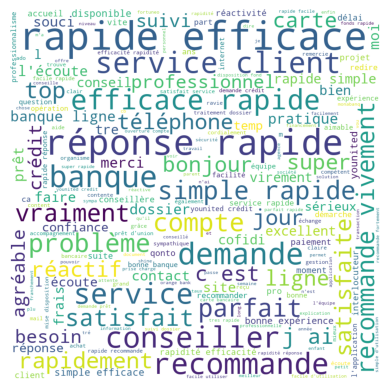

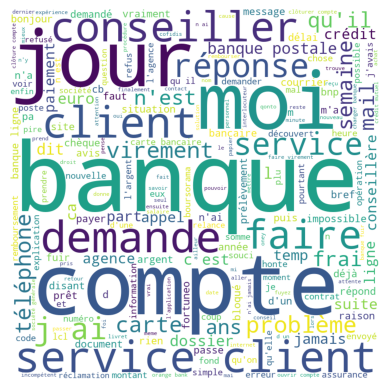

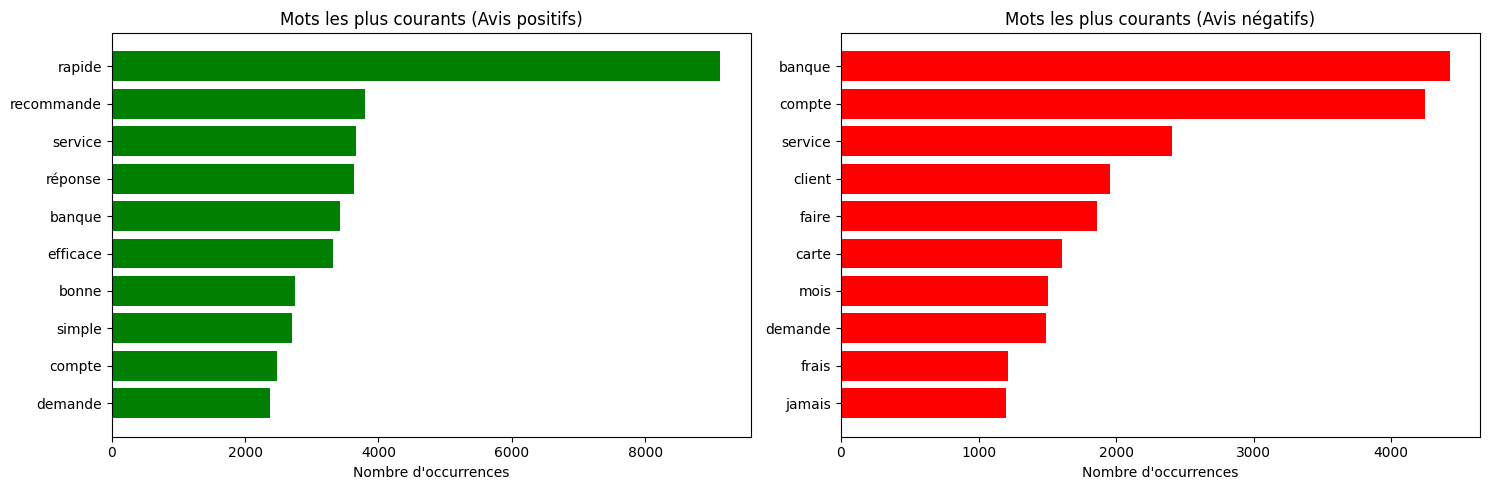

In [20]:
# Afficher les mots les plus courants dans les avis positifs et négatifs
positive_reviews = predictions.filter("label >= 4").select("MeaningfulWords").rdd.flatMap(lambda x: x[0]).collect()
negative_reviews = predictions.filter("label <= 2").select("MeaningfulWords").rdd.flatMap(lambda x: x[0]).collect()

# Afficher les nuages de mots
wordcloud_positive = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(positive_reviews))
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

wordcloud_negative = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(negative_reviews))
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.show()

# Afficher les mots les plus courants dans les avis positifs et négatifs
positive_word_counts = Counter(positive_reviews)
negative_word_counts = Counter(negative_reviews)

# Obtenir les 10 mots les plus courants dans chaque groupe
top_positive_words = positive_word_counts.most_common(10)
top_negative_words = negative_word_counts.most_common(10)

# Inverser l'ordre des données pour avoir la valeur la plus fréquente en haut
top_positive_words = top_positive_words[::-1]
top_negative_words = top_negative_words[::-1]

# Extraire les mots et leurs comptes pour chaque groupe
positive_words, positive_counts = zip(*top_positive_words)
negative_words, negative_counts = zip(*top_negative_words)

# Afficher les histogrammes pour chaque groupe
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.barh(positive_words, positive_counts, color='green')
plt.xlabel('Nombre d\'occurrences')
plt.title('Mots les plus courants (Avis positifs)')

plt.subplot(1, 2, 2)
plt.barh(negative_words, negative_counts, color='red')
plt.xlabel('Nombre d\'occurrences')
plt.title('Mots les plus courants (Avis négatifs)')

plt.tight_layout()
plt.show()


In [21]:
# Créer un transformateur de bigrammes
ngram = NGram(n=2, inputCol=swr.getOutputCol(), outputCol="bigrams")

# Créer un pipeline complet
pipeline = Pipeline(stages=[tokenizer, swr, hashTF, ngram, lr])

# Entraîner le modèle
model = pipeline.fit(train)

# Faire des prédictions sur l'ensemble de test
predictions = model.transform(test)
# Évaluer les performances du modèle
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/05/09 23:15:10 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/09 23:15:16 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/09 23:15:21 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/09 23:15:27 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


Accuracy: 0.8007997951263716
Precision: 0.7525289344452271
Recall: 0.8007997951263714
F1-score: 0.7710063423188703


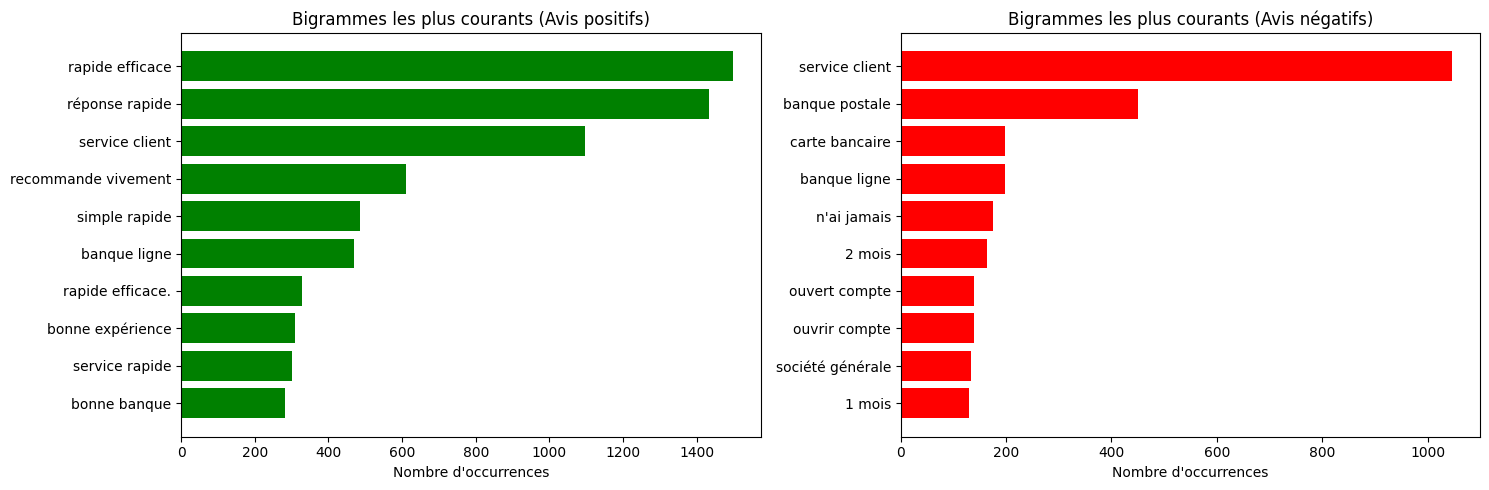

In [22]:
# Afficher les paires de mots les plus courantes dans les avis positifs et négatifs
positive_bigrams = predictions.filter("label >= 4").select("bigrams").rdd.flatMap(lambda x: x[0]).collect()
negative_bigrams = predictions.filter("label <= 2").select("bigrams").rdd.flatMap(lambda x: x[0]).collect()

# Compter les occurrences des bigrammes
positive_bigram_counts = Counter(positive_bigrams)
negative_bigram_counts = Counter(negative_bigrams)

# Obtenir les 10 bigrammes les plus courants dans chaque groupe
top_positive_bigrams = positive_bigram_counts.most_common(10)
top_negative_bigrams = negative_bigram_counts.most_common(10)

# Inverser l'ordre des données pour avoir la valeur la plus fréquente en haut
top_positive_bigrams = top_positive_bigrams[::-1]
top_negative_bigrams = top_negative_bigrams[::-1]

# Extraire les bigrammes et leurs comptes pour chaque groupe
positive_bigrams, positive_bigram_counts = zip(*top_positive_bigrams)
negative_bigrams, negative_bigram_counts = zip(*top_negative_bigrams)

# Afficher les histogrammes pour chaque groupe
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.barh(positive_bigrams, positive_bigram_counts, color='green')
plt.xlabel('Nombre d\'occurrences')
plt.title('Bigrammes les plus courants (Avis positifs)')

plt.subplot(1, 2, 2)
plt.barh(negative_bigrams, negative_bigram_counts, color='red')
plt.xlabel('Nombre d\'occurrences')
plt.title('Bigrammes les plus courants (Avis négatifs)')

plt.tight_layout()
plt.show()

# Arrêter le contexte Spark à la fin
spark.stop()

In [ ]:
# Créer une session Spark
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .getOrCreate()


# Sauvegarder le modèle
model_path = "modele_v1"
model.save(model_path)


# Arrêter le contexte Spark à la fin
spark.stop()